# CODE: Code for Optimizing Docking Enrichments

In [1]:
#Importa los paquetes necesarios
from __future__ import division
from pylab import *
import csv, os, random, sys, shutil, time
from emcee_code import emcee_code_function, modelo
from optparse import OptionParser
from scipy import stats
from optparse import OptionParser
import numpy
numpy.set_printoptions(threshold=numpy.nan)

parser=OptionParser()
tamano=14

Populating the interactive namespace from numpy and matplotlib


In [ ]:
parser.add_option("-i","--input", action="store", type="string", dest="InputFile", help="Path of the .csv input file. Special requirements: The values of the last column will be overwriten. The columns previous to the last one must contain the parameters used for the fitting.")
parser.add_option("-j","--jobname", action="store", type="string", dest="Jobname", help="Name of the job that is being run. No files or directories will ever be overwriten.")
parser.add_option("-n", "--param", action="store", type="int", dest="NumParam", help="Number of columns previous to the last one that will be considered as parameters for the MC fitting.")
parser.add_option("-t", "--train", action="store", type="int", dest="NumTrainMol", help="Number of random entries (rows) from the input file that will be considered as part of the training set. All the molecules that are not in the Training Set will be part of the Test Set.")
parser.add_option("-s", "--seed", action="store", type="int", dest="RandomSeed", help="Seed used for the semi-random selection of the entries used in the Training Set.")
parser.add_option("-d", "--threshold", action="store", type="int", dest="Threshold", help="Entries with an activity lower or equal than this value will be considered as active molecules.")
parser.add_option("-b", "--cboolean", action="store", type="int", dest="BooleanActivity", help="Number of the column (starting from 0) that is going to be overwritten depending on the numeric value of the activity (see option -th).")
parser.add_option("-a", "--cactivity", action="store", type="int", dest="NumericActivity", help="Number of the column (starting from 0) that contains the numeric activity of each entry.")

(options, args) = parser.parse_args()

In [2]:
inputfile=options.InputFile
Nombre=options.Jobname
numParam=options.NumParam

numTrainMol=options.NumTrainMol
semilla=options.RandomSeed
thresAct=options.Threshold #Por debajo (o igual) a este valor se considera el compuesto activo
coluAct=options.BooleanActivity
coluMIC=options.NumericActivity

#########################################################################################################################
start_mom = time.strftime("%c")
start_time = time.time()

if os.path.exists(Nombre)==True:
    sys.exit("There is already a job with the same name. Please change it. I will not override it to then see you mad at me.")
if os.path.exists(Nombre)==False:
    os.mkdir(Nombre)

mayomen=[]

for i in range(0, numParam):
    mayomen.append(-1)
#mayomen=[-1,-1,-1,-1,-1,-1] #-1 si entre menor mejor y 1 si entre mayor mejor

shutil.copy(inputfile, Nombre)
os.rename(Nombre+'/'+inputfile, Nombre+'/'+Nombre+'_In.csv' )
#ResultsDatabase=genfromtxt(inputfile, delimiter=',')
Datos=genfromtxt(Nombre + '/'+Nombre+'_In.csv', delimiter=',', skip_header=1) 

In [3]:
def arreglar(array):
    
    ignorar=len(array[0,:])-numParam-1
    
#Normaliza valores de las columnas    
    for j in range (0, numParam):
        norm=0
        colu=ignorar+j
        minimo=min(array[:,colu])
        maximo=max(array[:,colu])
        
        if mayomen[j]==-1:
            for k in range(0, len(array[:,colu])):
                array[k,colu]=array[k,colu]-maximo
            norm=min(array[:,colu])
            for l in range(0, len(array[:,colu])):
                array[l,colu]=array[l,colu]/norm
                
        if mayomen[j]==1:
            for m in range(0, len(array[:, colu])):
                array[m, colu]=array[m,colu]-minimo
            norm=max(array[:,colu])
            for n in range(0, len(array[:,colu])):
                array[n, colu]=array[n, colu]/norm 
    
#Asigna valor boolean a coluAct    
    for o in range(0,len(array[:,0])):
        if (array[o, coluMIC]<=thresAct):
            array[o,coluAct]=1
        if (array[o, coluMIC]>thresAct):
            array[o,coluAct]=2
    return array

In [4]:
#Arregla input
DatosArreg=arreglar(Datos)

#Asigna ciertas filas al training set
filasTrain=[]
TrainSet=zeros((numTrainMol, len(DatosArreg[0,:])))

for i in range(len(DatosArreg[0,:])):
    random.seed(semilla)
    filasTrain=random.sample(range(len(DatosArreg[:,0])), numTrainMol)
    
ndx=0
for j in range(0, len(DatosArreg[:,0])):
    if ((j in filasTrain)==True):
        TrainSet[ndx,:]=DatosArreg[j,:]
        ndx+=1 

#Asigna ciertas filas al test set
filasTest=[]
TestSet=zeros((len(Datos[:,0])-numTrainMol,len(Datos[0,:])))

for i in range(0, len(DatosArreg[:,0])):
    if ((i in filasTrain)==False):
        filasTest.append(i)
        
ndx=0
for k in range(0, len(DatosArreg[:,0])):
    if ((k in filasTest)==True):
        TestSet[ndx,:]=DatosArreg[k,:]
        ndx += 1

#Crea matriz con las propiedades a usar
matriz_propiedades_train = TrainSet[:,len(TrainSet[0,:])-1-numParam:(len(TrainSet[0,:])-1)]
matriz_propiedades_test = TestSet[:,len(TestSet[0,:])-1-numParam:(len(TestSet[0,:])-1)]
matriz_propiedades = DatosArreg[:,len(DatosArreg[0,:])-1-numParam:(len(DatosArreg[0,:])-1)]

#Crea arreglo con solo datos de actividad experimental
mic_train = TrainSet[:,coluMIC]  
mic_test = TestSet[:,coluMIC]  

## MonteCarlo

Mean acceptance fraction: 0.614 (Should be between 0.25 and 0.5 approximately)
Parameter = [16 50 84]
('param1 = ', array([ 5.5535522 ,  6.21708   ,  8.73363808]))
('param2 = ', array([ 4.91666926,  5.96052293,  8.87099361]))
('param3 = ', array([-9.9980735 , -3.1527058 , -2.20080908]))


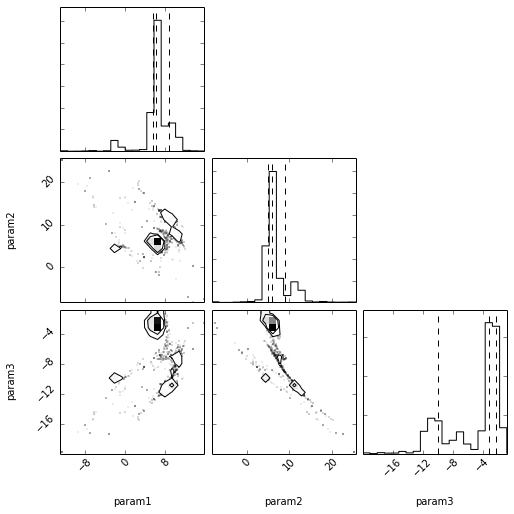

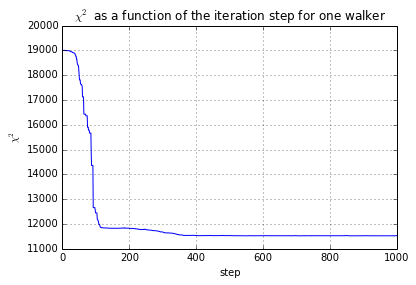

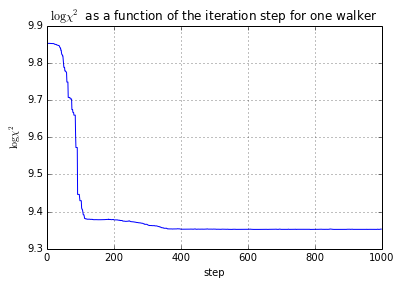

In [5]:
parametros_emcee = emcee_code_function(matriz_propiedades_train, mic_train, semilla, Nombre)
parametros_sin_error = parametros_emcee[:,1]

## Graficas y regresiones

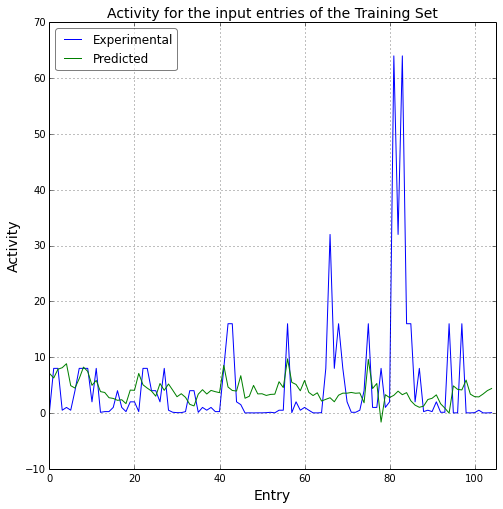

In [6]:
#Grafica la actividad predicha y experimental del Training Set en funcion de la entrada
figure(figsize=(8,8)); hold=True
plot(mic_train, label='Experimental')
plot(modelo(matriz_propiedades_train, parametros_sin_error), label='Predicted')
legend(fancybox=True, loc=2).get_frame().set_alpha(0.5)
title('Activity for the input entries of the Training Set', fontsize=tamano)
xlabel('Entry', fontsize=tamano)
ylabel('Activity', fontsize=tamano)
xlim(0,len(filasTrain))
grid()
savefig(Nombre + '/ActTrainSet.png')

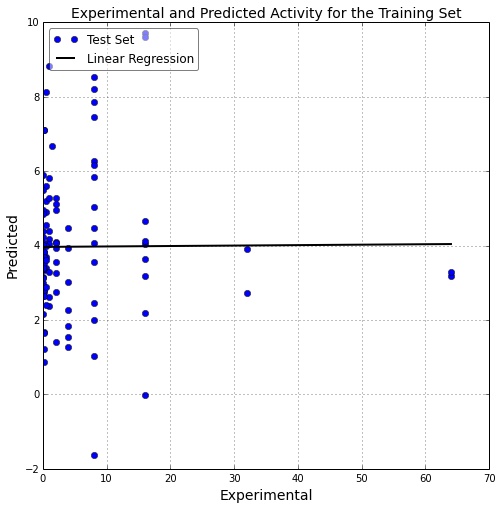

In [7]:
regre_train = stats.linregress(mic_train, modelo(matriz_propiedades_train, parametros_sin_error))
p_train=arange(min(mic_train), max(mic_train), 0.01)
lin_train=p_train*regre_train[0]+ regre_train[1]
#Grafica la actividad predicha y experimental del Training Set
figure(figsize=(8,8)); hold=True
plot(mic_train, modelo(matriz_propiedades_train, parametros_sin_error), 'bo', label='Test Set')
plot(p_train, lin_train, 'k-', label='Linear Regression', lw=2)
legend(fancybox=True, loc=2).get_frame().set_alpha(0.5)
title('Experimental and Predicted Activity for the Training Set', fontsize=tamano)
xlabel('Experimental', fontsize=tamano)
ylabel('Predicted', fontsize=tamano)
grid()
savefig(Nombre + '/ActTrainSetPredExp.png')

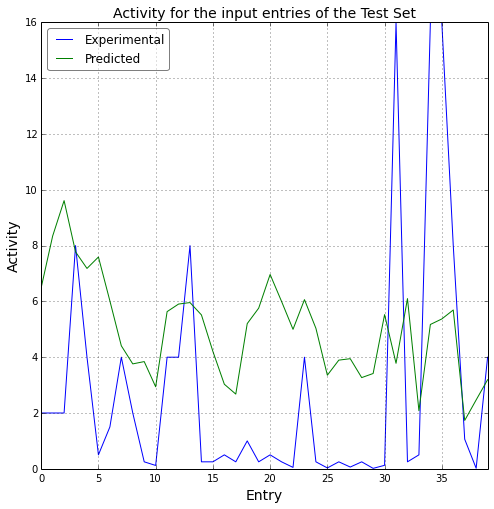

In [8]:
#Grafica la actividad predicha y experimental del Test Set en funcion de la entrada
figure(figsize=(8,8)); hold=True
plot(mic_test, label='Experimental')
plot(modelo(matriz_propiedades_test, parametros_sin_error), label='Predicted')
legend(fancybox=True, loc=2).get_frame().set_alpha(0.5)
title('Activity for the input entries of the Test Set', fontsize=tamano)
xlabel('Entry', fontsize=tamano)
ylabel('Activity', fontsize=tamano)
xlim(0,len(filasTest)-1)
grid()
savefig(Nombre + '/ActTestSet.png')

1599 1599


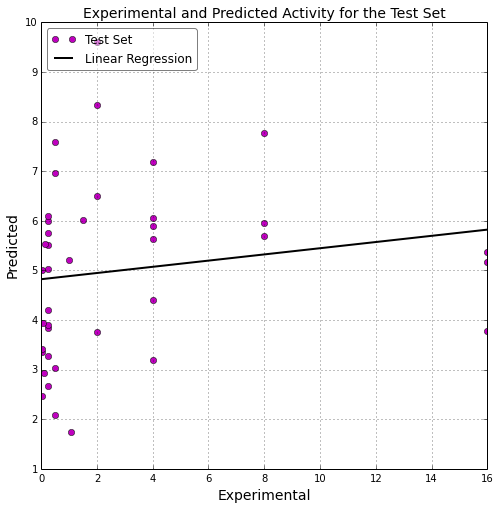

In [9]:
regre_test = stats.linregress(mic_test, modelo(matriz_propiedades_test, parametros_sin_error))
p_test=arange(min(mic_test), max(mic_test), 0.01)
lin_test=p_test*regre_test[0]+ regre_test[1]
#Grafica la actividad predicha y experimental del Test Set
figure(figsize=(8,8)); hold=True
plot(mic_test, modelo(matriz_propiedades_test, parametros_sin_error), 'mo', label='Test Set')
plot(p_test, lin_test, 'k-', label='Linear Regression', lw=2)
legend(fancybox=True, loc=2).get_frame().set_alpha(0.5)
title('Experimental and Predicted Activity for the Test Set', fontsize=tamano)
xlabel('Experimental', fontsize=tamano)
ylabel('Predicted', fontsize=tamano)
grid()
savefig(Nombre + '/ActTestSetPredExp.png')

## Enriquecimiento

In [10]:
#Agrega el valor de CODE un array
def CODEfunc(array, params):
    for i in range(0, len(array[:,0])):
        for j in range(0, len(params)):
            array[i,len(array[0,:])-1]+=params[j]*array[i,len(array[0,:])-1-len(params)+j]
    return array

#Ordena el array de menor a mayor segun los valores de numcol
def Ordenador(array, numcol):
    
    Ordered=array[array[:,numcol].argsort()]
    
    return Ordered

In [11]:
#Define un nuevo array con la columna de code
DatosArreg_code = CODEfunc(DatosArreg, parametros_sin_error)

In [12]:
#Crea array con la cantidad de compuestos screened en cada slot
def CompScreened(arrayinp):
    
    compuestos_totales=len(arrayinp[:,0])
    compuestos_screened=1
    porcentaje_screened=zeros(compuestos_totales+1)
    porcentaje_screened[0]=0
    
    for i in range(compuestos_totales):
        nuevo_procentaje=(compuestos_screened/compuestos_totales)*100
        compuestos_screened +=1
        porcentaje_screened[i+1]=nuevo_procentaje
        
    return porcentaje_screened

#Crea array con la cantidad de compuestos encontrados hasta cada slot
def ActScreened(array, numcol):
    
    arrayord=Ordenador(array, numcol)
    acttot=0
    actfound=0
    actscreen=zeros(len(array[:,0])+1)
    actscreen[0]=0
    
    for h in range(0, len(arrayord[:,0])):
        if (arrayord[h,coluAct] == 1): #Aca se busca el 1 en la columna 'actcol'
            acttot += 1
            
    for i in range(0, len(arrayord[:,0])):
        if (arrayord[i, coluAct] == 1):
            actfound += 1
        actpercent = actfound/acttot * 100
        actscreen[i+1]=actpercent
        
    return actscreen

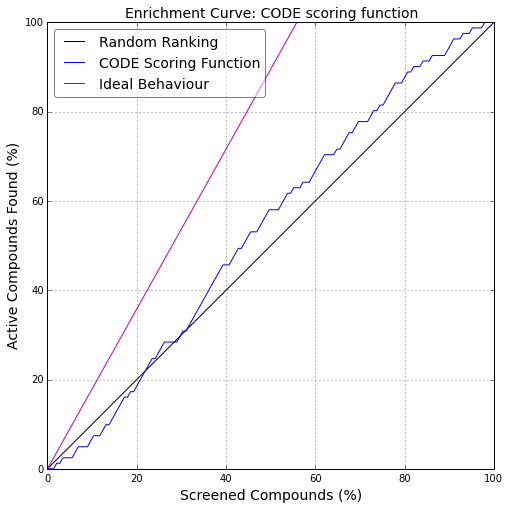

In [13]:
#Grafica curva de enriquecimiento ordenando segun valores de CODE
figure(figsize=(8,8)); hold=True
p=arange(0,101,1)
lin=p
plot(p,lin, 'k-', lw=1, label=r'Random Ranking')
plot(CompScreened(DatosArreg_code), ActScreened(CODEfunc(DatosArreg_code, parametros_sin_error), len(DatosArreg_code[0,:])-1), 'b-', lw=1, label=r'CODE Scoring Function')
plot(CompScreened(DatosArreg_code), ActScreened(CODEfunc(DatosArreg_code, parametros_sin_error), coluAct), 'm-', lw=1, label=r'Ideal Behaviour')
title(r'Enrichment Curve: CODE scoring function', fontsize=tamano)
xlabel(r'Screened Compounds (%)', fontsize=tamano)
ylabel(r'Active Compounds Found (%)', fontsize=tamano)
legend(fontsize=tamano, fancybox=True, loc=2).get_frame().set_alpha(0.5)
grid()
savefig(Nombre + '/' + 'EnrichmentCurveCODE.png')
#show()

In [14]:
finish_mom = time.strftime("%c")

In [17]:
arch = open(Nombre + '/' + Nombre + '.log', "a")
    
arch.write('Job name: ' + Nombre)
arch.write('\n Starting time: ' + str(start_mom))
arch.write('\n Input file: ' + inputfile)
arch.write('\n Number of parameters: ' + str(numParam))
arch.write('\n Number of molecules in the Training Set: ' + str(numTrainMol))
arch.write('\n Number of molecules in the Test Set: ' + str(len(DatosArreg[:,0])-numTrainMol))
arch.write('\n Total molecules imported: ' + str(len(DatosArreg[:,0])))
arch.write('\n Random seed: ' + str(semilla))
arch.write('\n Boolean activity set to column: ' + str(coluAct) + ' (starting from 0)')
arch.write('\n Numeric activity value taken from column: ' + str(coluMIC))
arch.write('\n Calculated activity values set in column: ' + str(len(DatosArreg[:,0])-1))
arch.write('\n Finish time: ' + str(finish_mom))
arch.write('\n Running time (s): ' + str(abs(time.time()-start_time)))  

arch.write('\n \n \n For the Monte Carlo (MC) calculation: ')
arch.write('\n \n The best parameters found were: ' + str(parametros_sin_error))
arch.write('\n Saved figure ' + Nombre + '/triangle.png contains the corner graphs of the MC run')
arch.write('\n Saved figure ' + Nombre + '/chi_squared.png contains the value of $chi^2$ as a function of the iteration step for one walker')
arch.write('\n Saved figure ' + Nombre + '/chi_squared_log.png contains the value of $log{chi^2}$ as a function of the iteration step for one walker')

arch.write('\n \n \n For the Training Set: ')
arch.write('\n \n The fitting line between experimental and predicted activity had an r^2 of: ' + str(regre_train[2]**2))
arch.write('\n The equation of this line is: PREDICT = ' + str(regre_train[0]) + '*EXPERIMENT + ' + str(regre_train[1]))
arch.write('\n Saved figure ' + Nombre + '/ActTrainSet.png contains the fitting of the predicted activity to the experimental one using an MC method for the Training Set')
arch.write('\n Saved figure ' + Nombre + '/ActTrainSetPredExp.png contains the predicted activities as a function of the experimental ones for the Training Set')


arch.write('\n \n \n For the Test Set: ')
arch.write('\n \n The fitting line between experimental and predicted activity had an r^2 of: ' + str(regre_test[2]**2))
arch.write('\n The equation of this line is: PREDICT = ' + str(regre_test[0]) + '*EXPERIMENT + ' + str(regre_test[1]))
arch.write('\n Saved figure ' + Nombre + '/ActTestSet.png contains the fitting of the predicted activity to the experimental one using an MC method for the Test Set')
arch.write('\n Saved figure ' + Nombre + '/ActTestSetPredExp.png contains the predicted activities as a function of the experimental ones for the Test Set')

arch.write('\n Saved figure ' + Nombre + '/EnrichmentCurveCODE.png contains the enrichment curve of the complete set of molecules when the compounds are sorted according to the CODE function value')

arch.close()
    
msj='Toda la informacion de este calculo se salvo en la carpeta: ' + Nombre
print msj

Toda la informacion de este calculo se salvo en la carpeta: test
